In [2]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import Category10
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [3]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm.csv", index_col=0, usecols=["gene", "BB9", "BB10", "BB17",
                                                                              "BB19", "BB20", "BB21",
                                                                              "BB11", "BB12", "BB18"])
print("Tamanho dos dados:", datos.shape)
datos.head()

Tamanho dos dados: (4293, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,45.6132,57.7381,35.4817,71.4413,75.5846,59.6099,93.7032,78.2685,75.4577
aaeB,48.4527,42.2968,41.1391,44.0555,47.6292,51.5953,56.3065,69.1718,58.5695
aaeR,49.0572,53.1486,33.4681,55.6848,43.8708,64.5169,51.3741,77.9266,79043.0000
aaeX,66.7322,64.9632,64.3814,81.0705,52586.0000,69.0053,64.9201,69.2443,56966.0000
aas,73.7846,77.6379,77.6300,65.1203,64.7268,77.6184,77.5343,95.9067,93.9019


In [4]:
datos = np.log2(datos+1)

In [5]:
q25 = np.quantile(datos, .25, interpolation="midpoint", axis=0)
q50 = np.quantile(datos, .5, interpolation="midpoint", axis=0)
q75 = np.quantile(datos, .75, interpolation="midpoint", axis=0)

upper = q75 + 1.5*(q75-q25)
lower = q25 - 1.5*(q75-q25)

In [6]:
rg = open("./data/reference_genes.txt", "r", newline="\n")
hkg = [i for i in rg.read().splitlines()]
print("Quantidade de genes housekeeping:", len(hkg))
print("-----------------------------------------------")
print(hkg)

Quantidade de genes housekeeping: 21
-----------------------------------------------
['cysG', 'hcaT', 'idnT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [7]:
X_train = datos.loc[hkg].dropna()
print("Número de genes de referência: ", X_train.shape[0])

Número de genes de referência:  21


In [8]:
d_cv = dict()
for idx, val in X_train.iterrows():
    d_cv[idx] = np.std(val)/np.mean(val)

In [9]:
cv_values = [i for i in d_cv.values()]
q25 = np.quantile(cv_values, q=.25)
q75 = np.quantile(cv_values, q=.75)
upper_hkg = q75 + 1.5*(q75 - q25)
lower_hkg = q25 - 1.5*(q75 - q25)

In [10]:
cv_values

[0.047510330894395825,
 0.034282436941015654,
 0.5082800362135752,
 0.08274603355028991,
 0.07550553167722314,
 0.052812539574405244,
 0.1593059342197117,
 0.22872084846542823,
 0.2935911425658469,
 0.18868773605291764,
 0.19799310052122365,
 0.29599030526449727,
 0.03718694477894635,
 0.20738773919228934,
 0.044124249004606285,
 0.02402531796880816,
 0.03399753444494476,
 0.18407738946242252,
 0.20048677275570292,
 0.2707966507718216,
 0.4188544734596423]

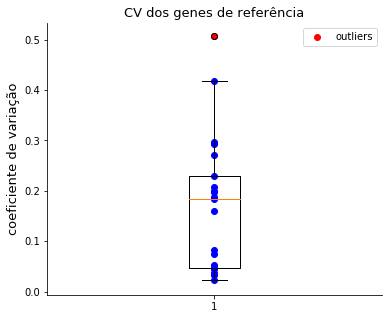

In [11]:
fig1 = plt.figure(figsize=(6,5))
i = 0
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("CV dos genes de referência", fontsize=13)
plt.ylabel("coeficiente de variação", fontsize=13)
for key in d_cv:
    if d_cv[key] <= upper_hkg and d_cv[key] >= lower_hkg:
        plt.scatter(1, d_cv[key], color="blue");
    else:
        plt.scatter(1, d_cv[key], color="red", label="outliers");
    i += 1
plt.boxplot(cv_values);
plt.legend();

In [12]:
print("max cv: ", upper_hkg)
print("------------ outliers -------------")
for key, val in d_cv.items():
    if val > upper_hkg or val < lower_hkg:
        print(key, val)
        
#X_train = X_train.drop("idnT")
X_train.shape

max cv:  0.5005366248219769
------------ outliers -------------
idnT 0.5082800362135752


(21, 9)

In [13]:
X_train = X_train.drop("idnT")

In [14]:
max_val = 1
min_val = -1
min_train = np.min(X_train)
max_train = np.max(X_train)
X_train = ((X_train - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [15]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [16]:
noise_input = 18
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  18
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                950       
_________________________________________________________________
dense_1 (Dense)              (None, 150)               7650      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1359      
_________________________________________________________________
reshape (Reshape)            (None, 9)                 0         
Total params: 9,959
Trainable params: 9,959
Non-trainable params: 0
_________________________________________________________________


In [18]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0], noise_input))
print("Dimension de los datos de entrada:", noise.shape)
data_fake = G.predict(noise)
print("Dimension de los ejemplos generados:", data_fake.shape)

Dimension de los datos de entrada: (20, 18)
Dimension de los ejemplos generados: (20, 9)


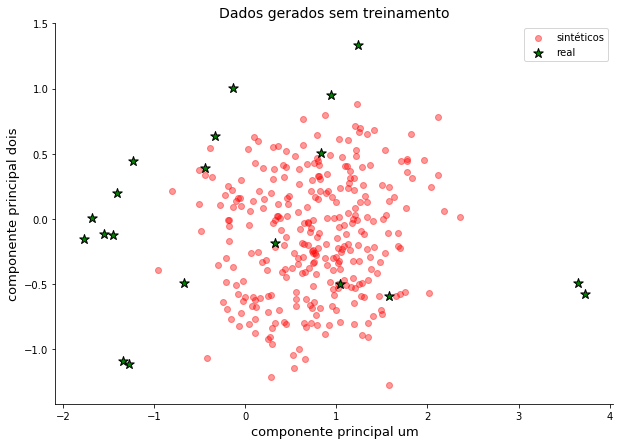

In [19]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)
X_train_pca
noise = np.random.normal(loc=0, scale=1, size=(300, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_fake_pca = pca_real.transform(x_noise)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="sintéticos", alpha=.4)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [20]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(32))
        model.add(Dropout(.1))
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [21]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [23]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [24]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    fscore = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_real = X_train.loc[np.random.choice(X_train.index.values, size=20, replace=False)]
        X_fake = G.predict(np.random.normal(0, 1, (20, noise_input)))
        X_test = np.concatenate((X_real, X_fake))
        y_test = np.concatenate((np.ones((20,1)), np.zeros((20,1))))
        y_predict = D.predict_classes(X_test)
        f1_lag = f1_score(y_test, y_predict)
        fscore.append(np.mean((y_predict - y_test)**2))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
        #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
        #    break
    return g_loss, d_loss, fscore

In [25]:
noise_input = 50
#Gerador
#optimizerG = Adam(lr=0.0001, beta_1=0.4)
optimizerG = SGD(lr=0.0001, momentum=0.92, decay=0.0001/2000)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
#optimizerD = Adam(lr=0.002, beta_1=0.9)
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/2000)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 9)                 11559     
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [26]:
ep = 2000
g_loss, d_loss, fscore = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/2000] [Discriminator::d_loss: 0.689433],[Generator::loss: 0.832698], 0.788181[sec]
epoch:[2/2000] [Discriminator::d_loss: 0.661279],[Generator::loss: 0.820577], 0.009813[sec]
epoch:[3/2000] [Discriminator::d_loss: 0.670216],[Generator::loss: 0.753510], 0.009680[sec]
epoch:[4/2000] [Discriminator::d_loss: 0.670014],[Generator::loss: 0.867551], 0.009485[sec]
epoch:[5/2000] [Discriminator::d_loss: 0.722182],[Generator::loss: 0.859219], 0.009715[sec]
epoch:[6/2000] [Discriminator::d_loss: 0.686949],[Generator::loss: 0.715833], 0.009729[sec]
epoch:[7/2000] [Discriminator::d_loss: 0.658685],[Generator::loss: 0.800106], 0.009770[sec]
epoch:[8/2000] [Discriminator::d_loss: 0.689358],[Generator::loss: 0.812236], 0.009789[sec]
epoch:[9/2000] [Discriminator::d_loss: 0.677581],[Generator::loss: 0.906805], 0.009785[sec]
epoch:[10/2000] [Discriminator::d_loss: 0.638871],[Generator::loss: 0.803268], 0.009568[sec]
epoch:[11/2000] [Discriminator::d_loss: 0.653358],[Generator::loss: 0.792692], 

epoch:[98/2000] [Discriminator::d_loss: 0.573464],[Generator::loss: 0.779052], 0.013636[sec]
epoch:[99/2000] [Discriminator::d_loss: 0.586754],[Generator::loss: 0.863081], 0.014099[sec]
epoch:[100/2000] [Discriminator::d_loss: 0.566049],[Generator::loss: 0.665128], 0.010236[sec]
epoch:[101/2000] [Discriminator::d_loss: 0.652521],[Generator::loss: 0.702824], 0.011268[sec]
epoch:[102/2000] [Discriminator::d_loss: 0.609316],[Generator::loss: 0.669736], 0.010318[sec]
epoch:[103/2000] [Discriminator::d_loss: 0.619477],[Generator::loss: 0.743812], 0.010081[sec]
epoch:[104/2000] [Discriminator::d_loss: 0.610647],[Generator::loss: 0.825326], 0.011495[sec]
epoch:[105/2000] [Discriminator::d_loss: 0.589070],[Generator::loss: 0.784446], 0.010599[sec]
epoch:[106/2000] [Discriminator::d_loss: 0.544711],[Generator::loss: 0.851909], 0.009926[sec]
epoch:[107/2000] [Discriminator::d_loss: 0.611445],[Generator::loss: 0.784751], 0.010425[sec]
epoch:[108/2000] [Discriminator::d_loss: 0.605643],[Generator:

epoch:[199/2000] [Discriminator::d_loss: 0.577751],[Generator::loss: 0.766407], 0.010574[sec]
epoch:[200/2000] [Discriminator::d_loss: 0.531846],[Generator::loss: 0.813920], 0.012433[sec]
epoch:[201/2000] [Discriminator::d_loss: 0.566595],[Generator::loss: 0.931306], 0.009724[sec]
epoch:[202/2000] [Discriminator::d_loss: 0.590343],[Generator::loss: 0.926607], 0.009768[sec]
epoch:[203/2000] [Discriminator::d_loss: 0.534871],[Generator::loss: 0.800668], 0.009952[sec]
epoch:[204/2000] [Discriminator::d_loss: 0.573401],[Generator::loss: 0.815766], 0.009797[sec]
epoch:[205/2000] [Discriminator::d_loss: 0.568100],[Generator::loss: 0.783598], 0.009875[sec]
epoch:[206/2000] [Discriminator::d_loss: 0.540896],[Generator::loss: 0.842411], 0.009763[sec]
epoch:[207/2000] [Discriminator::d_loss: 0.527498],[Generator::loss: 0.951174], 0.009594[sec]
epoch:[208/2000] [Discriminator::d_loss: 0.583778],[Generator::loss: 0.836947], 0.009459[sec]
epoch:[209/2000] [Discriminator::d_loss: 0.562107],[Generato

epoch:[299/2000] [Discriminator::d_loss: 0.549182],[Generator::loss: 0.947573], 0.016778[sec]
epoch:[300/2000] [Discriminator::d_loss: 0.495561],[Generator::loss: 0.838762], 0.010417[sec]
epoch:[301/2000] [Discriminator::d_loss: 0.524285],[Generator::loss: 0.942282], 0.009938[sec]
epoch:[302/2000] [Discriminator::d_loss: 0.537362],[Generator::loss: 0.836676], 0.009809[sec]
epoch:[303/2000] [Discriminator::d_loss: 0.604133],[Generator::loss: 0.875419], 0.009912[sec]
epoch:[304/2000] [Discriminator::d_loss: 0.529448],[Generator::loss: 0.863616], 0.009660[sec]
epoch:[305/2000] [Discriminator::d_loss: 0.611265],[Generator::loss: 0.865360], 0.009513[sec]
epoch:[306/2000] [Discriminator::d_loss: 0.583880],[Generator::loss: 0.854188], 0.009633[sec]
epoch:[307/2000] [Discriminator::d_loss: 0.541633],[Generator::loss: 0.909762], 0.009981[sec]
epoch:[308/2000] [Discriminator::d_loss: 0.518484],[Generator::loss: 0.874523], 0.009719[sec]
epoch:[309/2000] [Discriminator::d_loss: 0.549054],[Generato

epoch:[400/2000] [Discriminator::d_loss: 0.582279],[Generator::loss: 0.898615], 0.010069[sec]
epoch:[401/2000] [Discriminator::d_loss: 0.555756],[Generator::loss: 0.942256], 0.016883[sec]
epoch:[402/2000] [Discriminator::d_loss: 0.553374],[Generator::loss: 0.778669], 0.009866[sec]
epoch:[403/2000] [Discriminator::d_loss: 0.534609],[Generator::loss: 0.855486], 0.009892[sec]
epoch:[404/2000] [Discriminator::d_loss: 0.522971],[Generator::loss: 0.853006], 0.009883[sec]
epoch:[405/2000] [Discriminator::d_loss: 0.498768],[Generator::loss: 0.778182], 0.009537[sec]
epoch:[406/2000] [Discriminator::d_loss: 0.592723],[Generator::loss: 0.868472], 0.009651[sec]
epoch:[407/2000] [Discriminator::d_loss: 0.543485],[Generator::loss: 0.932357], 0.009808[sec]
epoch:[408/2000] [Discriminator::d_loss: 0.546656],[Generator::loss: 0.927618], 0.009681[sec]
epoch:[409/2000] [Discriminator::d_loss: 0.523304],[Generator::loss: 0.931997], 0.009565[sec]
epoch:[410/2000] [Discriminator::d_loss: 0.564311],[Generato

epoch:[500/2000] [Discriminator::d_loss: 0.571182],[Generator::loss: 0.799808], 0.010072[sec]
epoch:[501/2000] [Discriminator::d_loss: 0.580184],[Generator::loss: 0.799717], 0.012445[sec]
epoch:[502/2000] [Discriminator::d_loss: 0.490071],[Generator::loss: 0.869117], 0.010213[sec]
epoch:[503/2000] [Discriminator::d_loss: 0.529354],[Generator::loss: 0.955233], 0.010032[sec]
epoch:[504/2000] [Discriminator::d_loss: 0.511676],[Generator::loss: 1.015115], 0.009751[sec]
epoch:[505/2000] [Discriminator::d_loss: 0.534154],[Generator::loss: 0.914220], 0.009655[sec]
epoch:[506/2000] [Discriminator::d_loss: 0.550086],[Generator::loss: 0.921023], 0.009896[sec]
epoch:[507/2000] [Discriminator::d_loss: 0.572142],[Generator::loss: 1.074872], 0.009665[sec]
epoch:[508/2000] [Discriminator::d_loss: 0.489244],[Generator::loss: 1.057929], 0.009668[sec]
epoch:[509/2000] [Discriminator::d_loss: 0.560388],[Generator::loss: 1.011576], 0.009729[sec]
epoch:[510/2000] [Discriminator::d_loss: 0.509938],[Generato

epoch:[600/2000] [Discriminator::d_loss: 0.578425],[Generator::loss: 0.784247], 0.010105[sec]
epoch:[601/2000] [Discriminator::d_loss: 0.549306],[Generator::loss: 0.924765], 0.011564[sec]
epoch:[602/2000] [Discriminator::d_loss: 0.577208],[Generator::loss: 0.992510], 0.010335[sec]
epoch:[603/2000] [Discriminator::d_loss: 0.531052],[Generator::loss: 0.956360], 0.009988[sec]
epoch:[604/2000] [Discriminator::d_loss: 0.593448],[Generator::loss: 0.933606], 0.009700[sec]
epoch:[605/2000] [Discriminator::d_loss: 0.655993],[Generator::loss: 0.932058], 0.009679[sec]
epoch:[606/2000] [Discriminator::d_loss: 0.561080],[Generator::loss: 0.869057], 0.009923[sec]
epoch:[607/2000] [Discriminator::d_loss: 0.500985],[Generator::loss: 0.905451], 0.009596[sec]
epoch:[608/2000] [Discriminator::d_loss: 0.566247],[Generator::loss: 0.775671], 0.010001[sec]
epoch:[609/2000] [Discriminator::d_loss: 0.582360],[Generator::loss: 0.925556], 0.009594[sec]
epoch:[610/2000] [Discriminator::d_loss: 0.573422],[Generato

epoch:[699/2000] [Discriminator::d_loss: 0.548159],[Generator::loss: 0.963091], 0.016065[sec]
epoch:[700/2000] [Discriminator::d_loss: 0.573076],[Generator::loss: 0.825087], 0.011297[sec]
epoch:[701/2000] [Discriminator::d_loss: 0.596815],[Generator::loss: 0.989393], 0.011506[sec]
epoch:[702/2000] [Discriminator::d_loss: 0.563899],[Generator::loss: 0.921952], 0.009621[sec]
epoch:[703/2000] [Discriminator::d_loss: 0.547889],[Generator::loss: 0.924845], 0.010092[sec]
epoch:[704/2000] [Discriminator::d_loss: 0.597826],[Generator::loss: 0.954271], 0.009910[sec]
epoch:[705/2000] [Discriminator::d_loss: 0.591748],[Generator::loss: 1.017257], 0.009880[sec]
epoch:[706/2000] [Discriminator::d_loss: 0.607476],[Generator::loss: 0.854990], 0.009754[sec]
epoch:[707/2000] [Discriminator::d_loss: 0.581618],[Generator::loss: 1.014815], 0.009664[sec]
epoch:[708/2000] [Discriminator::d_loss: 0.580160],[Generator::loss: 0.767645], 0.009786[sec]
epoch:[709/2000] [Discriminator::d_loss: 0.586023],[Generato

epoch:[799/2000] [Discriminator::d_loss: 0.557932],[Generator::loss: 0.841290], 0.010221[sec]
epoch:[800/2000] [Discriminator::d_loss: 0.643683],[Generator::loss: 0.900797], 0.012123[sec]
epoch:[801/2000] [Discriminator::d_loss: 0.624356],[Generator::loss: 0.887423], 0.010224[sec]
epoch:[802/2000] [Discriminator::d_loss: 0.609349],[Generator::loss: 0.806101], 0.009610[sec]
epoch:[803/2000] [Discriminator::d_loss: 0.666040],[Generator::loss: 0.870876], 0.009778[sec]
epoch:[804/2000] [Discriminator::d_loss: 0.641940],[Generator::loss: 0.823172], 0.009804[sec]
epoch:[805/2000] [Discriminator::d_loss: 0.594099],[Generator::loss: 0.848114], 0.009825[sec]
epoch:[806/2000] [Discriminator::d_loss: 0.559511],[Generator::loss: 0.889112], 0.009696[sec]
epoch:[807/2000] [Discriminator::d_loss: 0.584581],[Generator::loss: 0.826384], 0.009778[sec]
epoch:[808/2000] [Discriminator::d_loss: 0.676567],[Generator::loss: 0.785290], 0.009714[sec]
epoch:[809/2000] [Discriminator::d_loss: 0.624374],[Generato

epoch:[890/2000] [Discriminator::d_loss: 0.679507],[Generator::loss: 0.927760], 0.011060[sec]
epoch:[891/2000] [Discriminator::d_loss: 0.620730],[Generator::loss: 0.860370], 0.011355[sec]
epoch:[892/2000] [Discriminator::d_loss: 0.660113],[Generator::loss: 0.859174], 0.009803[sec]
epoch:[893/2000] [Discriminator::d_loss: 0.692965],[Generator::loss: 0.905709], 0.009757[sec]
epoch:[894/2000] [Discriminator::d_loss: 0.680990],[Generator::loss: 0.968130], 0.009929[sec]
epoch:[895/2000] [Discriminator::d_loss: 0.660835],[Generator::loss: 0.915906], 0.009714[sec]
epoch:[896/2000] [Discriminator::d_loss: 0.618271],[Generator::loss: 0.992781], 0.009760[sec]
epoch:[897/2000] [Discriminator::d_loss: 0.635063],[Generator::loss: 0.773427], 0.009882[sec]
epoch:[898/2000] [Discriminator::d_loss: 0.651693],[Generator::loss: 0.840747], 0.009784[sec]
epoch:[899/2000] [Discriminator::d_loss: 0.679685],[Generator::loss: 0.786214], 0.009784[sec]
epoch:[900/2000] [Discriminator::d_loss: 0.610372],[Generato

epoch:[990/2000] [Discriminator::d_loss: 0.667824],[Generator::loss: 1.000469], 0.012462[sec]
epoch:[991/2000] [Discriminator::d_loss: 0.765772],[Generator::loss: 0.865071], 0.015053[sec]
epoch:[992/2000] [Discriminator::d_loss: 0.639292],[Generator::loss: 0.782913], 0.009883[sec]
epoch:[993/2000] [Discriminator::d_loss: 0.710643],[Generator::loss: 0.898745], 0.009934[sec]
epoch:[994/2000] [Discriminator::d_loss: 0.673759],[Generator::loss: 0.815524], 0.009997[sec]
epoch:[995/2000] [Discriminator::d_loss: 0.664975],[Generator::loss: 0.935399], 0.009515[sec]
epoch:[996/2000] [Discriminator::d_loss: 0.687593],[Generator::loss: 0.860302], 0.009879[sec]
epoch:[997/2000] [Discriminator::d_loss: 0.651901],[Generator::loss: 0.718878], 0.009638[sec]
epoch:[998/2000] [Discriminator::d_loss: 0.734601],[Generator::loss: 0.843152], 0.009549[sec]
epoch:[999/2000] [Discriminator::d_loss: 0.626304],[Generator::loss: 0.924410], 0.009920[sec]
epoch:[1000/2000] [Discriminator::d_loss: 0.642727],[Generat

epoch:[1090/2000] [Discriminator::d_loss: 0.654680],[Generator::loss: 0.854402], 0.010871[sec]
epoch:[1091/2000] [Discriminator::d_loss: 0.672161],[Generator::loss: 0.730327], 0.011895[sec]
epoch:[1092/2000] [Discriminator::d_loss: 0.689210],[Generator::loss: 0.790744], 0.009799[sec]
epoch:[1093/2000] [Discriminator::d_loss: 0.733396],[Generator::loss: 0.967559], 0.009721[sec]
epoch:[1094/2000] [Discriminator::d_loss: 0.645392],[Generator::loss: 0.758577], 0.009778[sec]
epoch:[1095/2000] [Discriminator::d_loss: 0.645765],[Generator::loss: 0.877224], 0.009663[sec]
epoch:[1096/2000] [Discriminator::d_loss: 0.688884],[Generator::loss: 0.823557], 0.009596[sec]
epoch:[1097/2000] [Discriminator::d_loss: 0.755508],[Generator::loss: 0.840287], 0.009737[sec]
epoch:[1098/2000] [Discriminator::d_loss: 0.670562],[Generator::loss: 0.791457], 0.009705[sec]
epoch:[1099/2000] [Discriminator::d_loss: 0.640580],[Generator::loss: 0.704134], 0.009842[sec]
epoch:[1100/2000] [Discriminator::d_loss: 0.649986

epoch:[1189/2000] [Discriminator::d_loss: 0.734049],[Generator::loss: 0.833240], 0.010838[sec]
epoch:[1190/2000] [Discriminator::d_loss: 0.768451],[Generator::loss: 0.750164], 0.011897[sec]
epoch:[1191/2000] [Discriminator::d_loss: 0.723043],[Generator::loss: 0.842371], 0.009621[sec]
epoch:[1192/2000] [Discriminator::d_loss: 0.684564],[Generator::loss: 0.644061], 0.009695[sec]
epoch:[1193/2000] [Discriminator::d_loss: 0.705975],[Generator::loss: 0.896711], 0.009947[sec]
epoch:[1194/2000] [Discriminator::d_loss: 0.692196],[Generator::loss: 0.818424], 0.009690[sec]
epoch:[1195/2000] [Discriminator::d_loss: 0.726396],[Generator::loss: 0.764035], 0.009717[sec]
epoch:[1196/2000] [Discriminator::d_loss: 0.677144],[Generator::loss: 0.783885], 0.009880[sec]
epoch:[1197/2000] [Discriminator::d_loss: 0.702453],[Generator::loss: 0.622538], 0.009539[sec]
epoch:[1198/2000] [Discriminator::d_loss: 0.729643],[Generator::loss: 0.839953], 0.010328[sec]
epoch:[1199/2000] [Discriminator::d_loss: 0.659813

epoch:[1290/2000] [Discriminator::d_loss: 0.711492],[Generator::loss: 0.797280], 0.010172[sec]
epoch:[1291/2000] [Discriminator::d_loss: 0.735234],[Generator::loss: 0.686217], 0.013896[sec]
epoch:[1292/2000] [Discriminator::d_loss: 0.674418],[Generator::loss: 0.786820], 0.009741[sec]
epoch:[1293/2000] [Discriminator::d_loss: 0.658699],[Generator::loss: 0.805378], 0.010648[sec]
epoch:[1294/2000] [Discriminator::d_loss: 0.721720],[Generator::loss: 0.694146], 0.010014[sec]
epoch:[1295/2000] [Discriminator::d_loss: 0.670604],[Generator::loss: 0.733999], 0.009736[sec]
epoch:[1296/2000] [Discriminator::d_loss: 0.736621],[Generator::loss: 0.782785], 0.010441[sec]
epoch:[1297/2000] [Discriminator::d_loss: 0.711237],[Generator::loss: 0.777235], 0.009794[sec]
epoch:[1298/2000] [Discriminator::d_loss: 0.676911],[Generator::loss: 0.703027], 0.009568[sec]
epoch:[1299/2000] [Discriminator::d_loss: 0.664664],[Generator::loss: 0.777471], 0.009664[sec]
epoch:[1300/2000] [Discriminator::d_loss: 0.701529

epoch:[1390/2000] [Discriminator::d_loss: 0.688134],[Generator::loss: 0.605515], 0.010730[sec]
epoch:[1391/2000] [Discriminator::d_loss: 0.707974],[Generator::loss: 0.696914], 0.012226[sec]
epoch:[1392/2000] [Discriminator::d_loss: 0.676069],[Generator::loss: 0.719957], 0.009665[sec]
epoch:[1393/2000] [Discriminator::d_loss: 0.683282],[Generator::loss: 0.788582], 0.010991[sec]
epoch:[1394/2000] [Discriminator::d_loss: 0.704905],[Generator::loss: 0.790915], 0.009944[sec]
epoch:[1395/2000] [Discriminator::d_loss: 0.696554],[Generator::loss: 0.762317], 0.009718[sec]
epoch:[1396/2000] [Discriminator::d_loss: 0.676280],[Generator::loss: 0.816902], 0.009684[sec]
epoch:[1397/2000] [Discriminator::d_loss: 0.705686],[Generator::loss: 0.808743], 0.009652[sec]
epoch:[1398/2000] [Discriminator::d_loss: 0.683607],[Generator::loss: 0.807908], 0.009912[sec]
epoch:[1399/2000] [Discriminator::d_loss: 0.689996],[Generator::loss: 0.769041], 0.010018[sec]
epoch:[1400/2000] [Discriminator::d_loss: 0.649819

epoch:[1490/2000] [Discriminator::d_loss: 0.713431],[Generator::loss: 0.776716], 0.010698[sec]
epoch:[1491/2000] [Discriminator::d_loss: 0.690273],[Generator::loss: 0.834647], 0.015986[sec]
epoch:[1492/2000] [Discriminator::d_loss: 0.678705],[Generator::loss: 0.728695], 0.009622[sec]
epoch:[1493/2000] [Discriminator::d_loss: 0.736671],[Generator::loss: 0.710972], 0.009893[sec]
epoch:[1494/2000] [Discriminator::d_loss: 0.701992],[Generator::loss: 0.761301], 0.009969[sec]
epoch:[1495/2000] [Discriminator::d_loss: 0.701089],[Generator::loss: 0.755916], 0.009957[sec]
epoch:[1496/2000] [Discriminator::d_loss: 0.719876],[Generator::loss: 0.776414], 0.009708[sec]
epoch:[1497/2000] [Discriminator::d_loss: 0.671399],[Generator::loss: 0.648447], 0.009522[sec]
epoch:[1498/2000] [Discriminator::d_loss: 0.688886],[Generator::loss: 0.805233], 0.009677[sec]
epoch:[1499/2000] [Discriminator::d_loss: 0.693615],[Generator::loss: 0.786788], 0.009762[sec]
epoch:[1500/2000] [Discriminator::d_loss: 0.660987

epoch:[1590/2000] [Discriminator::d_loss: 0.732856],[Generator::loss: 0.736133], 0.012159[sec]
epoch:[1591/2000] [Discriminator::d_loss: 0.736938],[Generator::loss: 0.779083], 0.011880[sec]
epoch:[1592/2000] [Discriminator::d_loss: 0.675845],[Generator::loss: 0.641692], 0.009908[sec]
epoch:[1593/2000] [Discriminator::d_loss: 0.727275],[Generator::loss: 0.740938], 0.010036[sec]
epoch:[1594/2000] [Discriminator::d_loss: 0.677144],[Generator::loss: 0.711549], 0.009955[sec]
epoch:[1595/2000] [Discriminator::d_loss: 0.688890],[Generator::loss: 0.737263], 0.009746[sec]
epoch:[1596/2000] [Discriminator::d_loss: 0.698317],[Generator::loss: 0.745197], 0.009483[sec]
epoch:[1597/2000] [Discriminator::d_loss: 0.674232],[Generator::loss: 0.787417], 0.009584[sec]
epoch:[1598/2000] [Discriminator::d_loss: 0.734095],[Generator::loss: 0.784577], 0.009701[sec]
epoch:[1599/2000] [Discriminator::d_loss: 0.670291],[Generator::loss: 0.784920], 0.009429[sec]
epoch:[1600/2000] [Discriminator::d_loss: 0.659481

epoch:[1692/2000] [Discriminator::d_loss: 0.703909],[Generator::loss: 0.679421], 0.012110[sec]
epoch:[1693/2000] [Discriminator::d_loss: 0.701488],[Generator::loss: 0.674994], 0.012794[sec]
epoch:[1694/2000] [Discriminator::d_loss: 0.702269],[Generator::loss: 0.760929], 0.010141[sec]
epoch:[1695/2000] [Discriminator::d_loss: 0.698046],[Generator::loss: 0.721807], 0.010131[sec]
epoch:[1696/2000] [Discriminator::d_loss: 0.707744],[Generator::loss: 0.691304], 0.009567[sec]
epoch:[1697/2000] [Discriminator::d_loss: 0.700138],[Generator::loss: 0.712145], 0.009648[sec]
epoch:[1698/2000] [Discriminator::d_loss: 0.703502],[Generator::loss: 0.760398], 0.009548[sec]
epoch:[1699/2000] [Discriminator::d_loss: 0.705179],[Generator::loss: 0.819696], 0.009588[sec]
epoch:[1700/2000] [Discriminator::d_loss: 0.686212],[Generator::loss: 0.741276], 0.009745[sec]
epoch:[1701/2000] [Discriminator::d_loss: 0.704008],[Generator::loss: 0.676774], 0.009577[sec]
epoch:[1702/2000] [Discriminator::d_loss: 0.703790

epoch:[1792/2000] [Discriminator::d_loss: 0.664642],[Generator::loss: 0.752825], 0.011402[sec]
epoch:[1793/2000] [Discriminator::d_loss: 0.652966],[Generator::loss: 0.772705], 0.011539[sec]
epoch:[1794/2000] [Discriminator::d_loss: 0.659385],[Generator::loss: 0.799554], 0.009632[sec]
epoch:[1795/2000] [Discriminator::d_loss: 0.660663],[Generator::loss: 0.787654], 0.009835[sec]
epoch:[1796/2000] [Discriminator::d_loss: 0.716731],[Generator::loss: 0.757226], 0.009538[sec]
epoch:[1797/2000] [Discriminator::d_loss: 0.694901],[Generator::loss: 0.730971], 0.009824[sec]
epoch:[1798/2000] [Discriminator::d_loss: 0.681813],[Generator::loss: 0.736547], 0.009632[sec]
epoch:[1799/2000] [Discriminator::d_loss: 0.709472],[Generator::loss: 0.744894], 0.009827[sec]
epoch:[1800/2000] [Discriminator::d_loss: 0.702700],[Generator::loss: 0.746994], 0.009740[sec]
epoch:[1801/2000] [Discriminator::d_loss: 0.655583],[Generator::loss: 0.720114], 0.009807[sec]
epoch:[1802/2000] [Discriminator::d_loss: 0.682264

epoch:[1893/2000] [Discriminator::d_loss: 0.663939],[Generator::loss: 0.767130], 0.011231[sec]
epoch:[1894/2000] [Discriminator::d_loss: 0.677376],[Generator::loss: 0.738307], 0.015578[sec]
epoch:[1895/2000] [Discriminator::d_loss: 0.697216],[Generator::loss: 0.728415], 0.010729[sec]
epoch:[1896/2000] [Discriminator::d_loss: 0.693279],[Generator::loss: 0.747790], 0.009671[sec]
epoch:[1897/2000] [Discriminator::d_loss: 0.657981],[Generator::loss: 0.735727], 0.009744[sec]
epoch:[1898/2000] [Discriminator::d_loss: 0.695981],[Generator::loss: 0.769013], 0.009621[sec]
epoch:[1899/2000] [Discriminator::d_loss: 0.676824],[Generator::loss: 0.769073], 0.009739[sec]
epoch:[1900/2000] [Discriminator::d_loss: 0.653886],[Generator::loss: 0.701759], 0.009601[sec]
epoch:[1901/2000] [Discriminator::d_loss: 0.672234],[Generator::loss: 0.771583], 0.009636[sec]
epoch:[1902/2000] [Discriminator::d_loss: 0.674867],[Generator::loss: 0.732111], 0.009687[sec]
epoch:[1903/2000] [Discriminator::d_loss: 0.679194

epoch:[1995/2000] [Discriminator::d_loss: 0.682437],[Generator::loss: 0.720401], 0.010520[sec]
epoch:[1996/2000] [Discriminator::d_loss: 0.668666],[Generator::loss: 0.774994], 0.011929[sec]
epoch:[1997/2000] [Discriminator::d_loss: 0.677099],[Generator::loss: 0.741787], 0.011242[sec]
epoch:[1998/2000] [Discriminator::d_loss: 0.689610],[Generator::loss: 0.738324], 0.009997[sec]
epoch:[1999/2000] [Discriminator::d_loss: 0.662835],[Generator::loss: 0.753361], 0.009850[sec]
epoch:[2000/2000] [Discriminator::d_loss: 0.669331],[Generator::loss: 0.782201], 0.009746[sec]


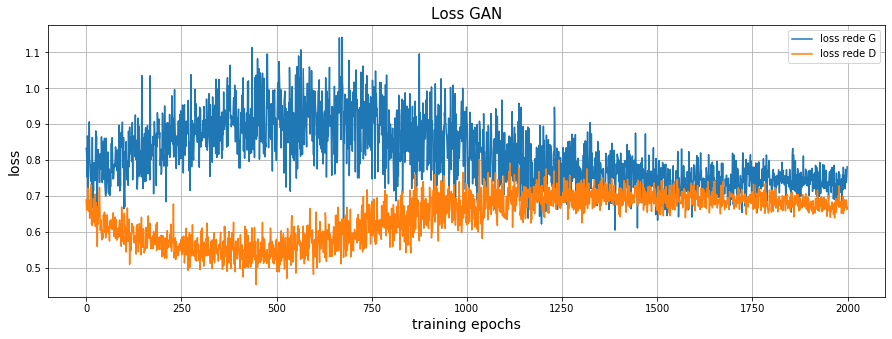

In [27]:
plt.figure(figsize=(15,5))
plt.title("Loss GAN", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("training epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

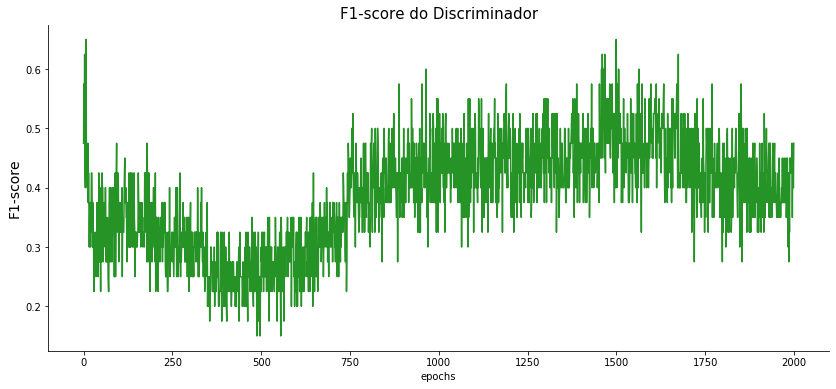

In [28]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("F1-score do Discriminador", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("F1-score", fontsize=14)
plt.plot(range(len(fscore)), fscore, color="green", alpha=.85);

(20, 2) (300, 2)


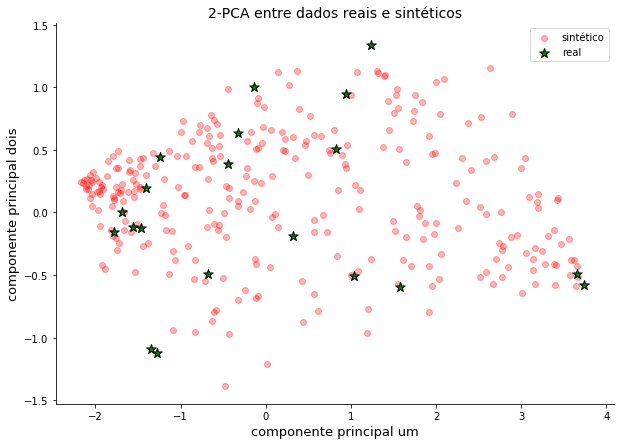

In [29]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(300, noise_input)))
X_fake_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_fake_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [73]:
score = []
for i in range(5000):
    X_sint = G.predict(np.random.normal(0, 1, (X_sint.shape[0], noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
    y_predict = D.predict_classes(X_test)
    score.append(np.mean((y_test - y_predict)**2))

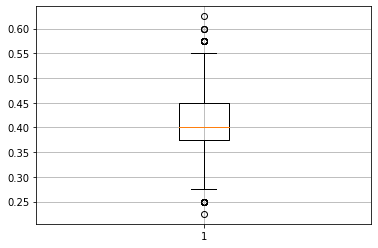

In [74]:
plt.grid("y")
plt.boxplot(score);

In [75]:
X_nov = np.concatenate((X_train, X_sint))

In [76]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(kernel="poly", degree=2, gamma='scale').fit(X_train)

np.mean(clf.predict(X_nov) == 1)

0.575

In [85]:
datos = ((datos - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
datos.shape

(4293, 9)

In [86]:
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,-1.021960,-0.979435,-1.070980,-0.936075,-0.964250,-1.031994,-0.934337,-0.939543,-0.937269
aaeB,-1.009480,-1.042995,-1.041304,-1.034891,-1.060889,-1.063096,-1.039629,-0.965042,-0.989310
aaeR,-1.006916,-0.996388,-1.082667,-0.987112,-1.078005,-1.014922,-1.058494,-0.940447,0.509951
aaeX,-0.943096,-0.955260,-0.950883,-0.910106,0.425601,-1.000392,-1.010278,-0.964826,0.441659
aas,-0.922192,-0.918634,-0.912901,-0.955073,-0.996782,-0.974946,-0.973578,-0.897515,-0.892211


In [87]:
datos = datos.drop(hkg)
datos.shape

(4272, 9)

In [89]:
predict_cand = clf.predict(datos)

In [92]:
cand = datos[predict_cand == 1]
no_cand = datos[predict_cand == -1]

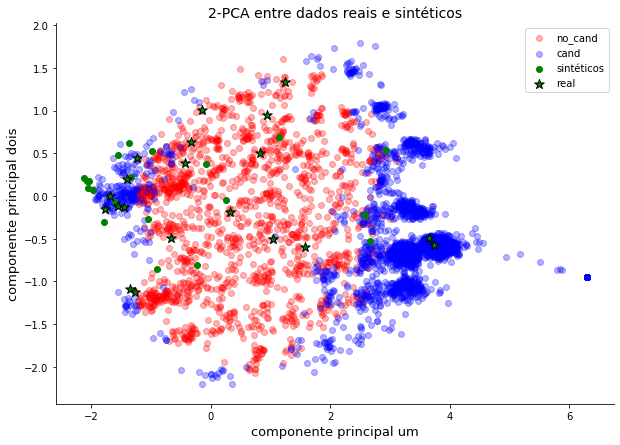

In [95]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand[:,0], X_cand[:,1], color="blue", label="cand",alpha=.3)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="green", label="sintéticos",alpha=1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();